# Imports

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

# Dataset and Preprocessing

In [3]:
ratings = pd.read_csv('Small/data/ratings.csv')
ratings


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
movie_encoder = LabelEncoder()
user_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['movie_idx'] = movie_encoder.fit_transform(ratings['movieId'])
ratings


,userId,movieId,rating,timestamp,user_idx,movie_idx
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,9416
100832,610,168248,5.0,1493850091,609,9443
100833,610,168250,5.0,1494273047,609,9444
100834,610,168252,5.0,1493846352,609,9445


In [5]:
train_ratings, test_ratings = train_test_split(ratings.values, test_size=0.2, random_state=0)
train_ratings = pd.DataFrame(train_ratings, columns=ratings.columns)
test_ratings = pd.DataFrame(test_ratings, columns=ratings.columns)


In [6]:
train_ratings


,userId,movieId,rating,timestamp,user_idx,movie_idx
0,483.0,8529.0,4.0,1.215545e+09,482.0,5213.0
1,599.0,33437.0,2.5,1.498518e+09,598.0,5879.0
2,247.0,5349.0,2.0,1.467645e+09,246.0,3814.0
3,111.0,7361.0,3.5,1.516141e+09,110.0,4900.0
4,610.0,57504.0,4.5,1.493848e+09,609.0,6651.0
...,...,...,...,...,...,...
80663,140.0,1393.0,4.0,9.496673e+08,139.0,1072.0
80664,304.0,1676.0,4.0,8.962684e+08,303.0,1260.0
80665,288.0,2529.0,5.0,9.761393e+08,287.0,1904.0
80666,292.0,1307.0,3.0,1.323632e+09,291.0,1004.0


In [7]:
test_ratings


,userId,movieId,rating,timestamp,user_idx,movie_idx
0,276.0,780.0,5.0,8.583504e+08,275.0,615.0
1,599.0,7624.0,2.5,1.519236e+09,598.0,4970.0
2,483.0,1320.0,2.5,1.215895e+09,482.0,1008.0
3,202.0,3448.0,3.0,9.749241e+08,201.0,2576.0
4,274.0,60291.0,4.0,1.296947e+09,273.0,6763.0
...,...,...,...,...,...,...
20163,356.0,6620.0,2.0,1.229140e+09,355.0,4476.0
20164,538.0,5618.0,5.0,1.307846e+09,537.0,3979.0
20165,82.0,2987.0,3.5,1.084468e+09,81.0,2248.0
20166,474.0,6787.0,4.0,1.064172e+09,473.0,4561.0


In [8]:
def data_loader(data, batch_size, n_users, n_items):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_items - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_idx')['movie_idx'].apply(list).reset_index()
    user_indices = [user_idx for user_idx in range(n_users)]

    if n_users < batch_size:
        users = [random.choice(user_indices) for _ in range(batch_size)]
    else:
        users = random.sample(user_indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users, columns=['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how='right', left_on='user_idx', right_on='users')
    pos_items = interected_items_df['movie_idx'].apply(lambda x: random.choice(x)).values
    neg_items = interected_items_df['movie_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_users,
        torch.LongTensor(list(neg_items)).to(device) + n_users
    )


# Models

### LightGCN

In [9]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


### NGCFConv

In [10]:
class NGCFConv(MessagePassing):
    def __init__(self, latent_dim, dropout, bias=True, **kwargs):
        super(NGCFConv, self).__init__(aggr='add', **kwargs)

        self.dropout = dropout

        self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
        self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

        self.init_parameters()

    def init_parameters(self):
        nn.init.xavier_uniform_(self.lin_1.weight)
        nn.init.xavier_uniform_(self.lin_2.weight)

    def forward(self, x, edge_index):
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        out = self.propagate(edge_index, x=(x, x), norm=norm)

        out += self.lin_1(x)
        out = F.dropout(out, self.dropout, self.training)
        return F.leaky_relu(out)

    def message(self, x_j, x_i, norm):
        return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))


In [11]:
class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim,
        num_layers,
        num_users,
        num_items,
        model,  # 'NGCF' or 'LightGCN'
        dropout=0.1  # Only used in NGCF
    ):
        super(RecSysGNN, self).__init__()

        assert (model == 'NGCF' or model == 'LightGCN'), 'Model must be NGCF or LightGCN'
        self.model = model
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)

        if self.model == 'NGCF':
            self.convs = nn.ModuleList(
                NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
            )
        else:
            self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

        self.init_parameters()

    def init_parameters(self):
        if self.model == 'NGCF':
            nn.init.xavier_uniform_(self.embedding.weight, gain=1)
        else:
            nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = (
            torch.cat(embs, dim=-1) if self.model == 'NGCF'
            else torch.mean(torch.stack(embs, dim=0), dim=0)
        )

        return emb0, out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )


# Loss function

In [12]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
    reg_loss = (1 / 2) * (
        user_emb0.norm().pow(2) +
        pos_emb0.norm().pow(2) +
        neg_emb0.norm().pow(2)
    ) / float(len(users))

    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss


# Training

In [13]:
n_users, n_items = ratings['user_idx'].nunique(), ratings['movie_idx'].nunique()

u_t = torch.LongTensor(train_ratings.user_idx)
i_t = torch.LongTensor(train_ratings.movie_idx) + n_users
train_edge_index = torch.stack((
    torch.cat([u_t, i_t]),
    torch.cat([i_t, u_t])
)).to(device)
train_edge_index


tensor([[ 482,  598,  246,  ..., 2514, 1614, 5510],
        [5823, 6489, 4424,  ...,  287,  291,  439]], device='cuda:0')

In [14]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005


In [15]:
def train(model, optimizer, train_df):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []

    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train_ratings)/BATCH_SIZE)

        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []

        model.train()
        for batch_idx in range(n_batch):

            optimizer.zero_grad()

            users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        loss_list_epoch.append(round(np.mean(final_loss_list), 4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list), 4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))

    return (
        loss_list_epoch,
        bpr_loss_list_epoch,
        reg_loss_list_epoch,
    )


### LightGCN

In [16]:
lightgcn = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
    model='LightGCN'
).to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)


In [17]:
light_loss, light_bpr, light_reg = train(lightgcn, optimizer, train_ratings)


  0%|          | 0/50 [00:00<?, ?it/s]

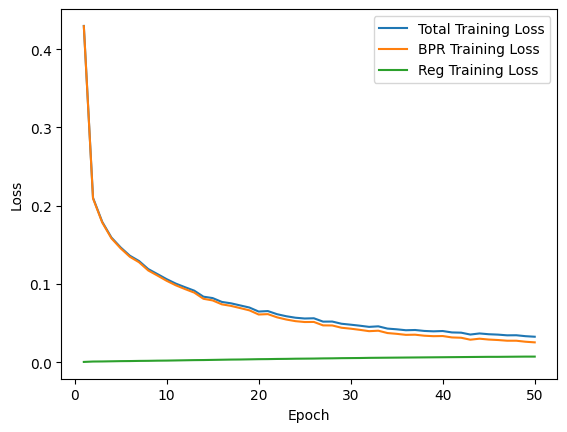

In [18]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### NGCF

In [19]:
ngcf = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
    model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)


In [20]:
ngcf_loss, ngcf_bpr, ngcf_reg = train(ngcf, optimizer, train_ratings)


  0%|          | 0/50 [00:00<?, ?it/s]

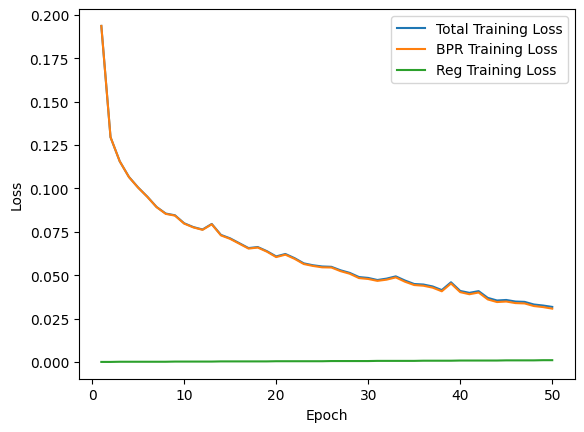

In [21]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')
plt.plot(epoch_list, ngcf_reg, label='Reg Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Recommendation

In [22]:
def recommend_movies(model: torch.nn, K: int):
    model.eval()
    with torch.no_grad():
        _, out = model(train_edge_index)
        user_embeddings, item_embeddings = torch.split(out, (n_users, n_items))

        relevance_score = torch.matmul(user_embeddings, torch.transpose(item_embeddings, 0, 1))

        topk_relevance_indices = torch.topk(relevance_score, K).indices
        recommendations = pd.DataFrame(topk_relevance_indices.cpu().numpy(), columns=['top_indx_'+str(x+1) for x in range(K)])
        recommendations['user_idx'] = recommendations.index
        recommendations['recommended_movies'] = recommendations[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
        recommendations = recommendations[['user_idx', 'recommended_movies']]

        recommendations['userId'] = recommendations['user_idx'].apply(lambda x: user_encoder.inverse_transform([x]).item())
        recommendations['recommended_movies'] = recommendations['recommended_movies'].apply(lambda x: list(movie_encoder.inverse_transform(x)))

        recommendations = recommendations[['userId', 'recommended_movies']]

    return recommendations


In [23]:
lightgcn_recommendations = recommend_movies(lightgcn, 10)
lightgcn_recommendations.to_csv('Small/recommendations/lightgcn.csv')
lightgcn_recommendations


,userId,recommended_movies
0,1,"[260, 1210, 1196, 2641, 1198, 2094, 1270, 2628..."
1,2,"[79132, 74458, 131724, 109487, 99114, 318, 915..."
2,3,"[5181, 5764, 7899, 6835, 5746, 26409, 70946, 7..."
3,4,"[1288, 2396, 608, 800, 1719, 1617, 2336, 910, ..."
4,5,"[590, 296, 318, 356, 457, 110, 150, 593, 592, ..."
...,...,...
605,606,"[6803, 56333, 5073, 4252, 7109, 1857, 30890, 4..."
606,607,"[480, 1210, 1270, 318, 1580, 589, 356, 1, 2628..."
607,608,"[1210, 1676, 589, 1527, 3793, 480, 32, 2706, 2..."
608,609,"[292, 137, 592, 161, 454, 1161, 434, 457, 185,..."


In [24]:
ngcf_recommendations = recommend_movies(ngcf, 10)
ngcf_recommendations.to_csv('Small/recommendations/ngcf.csv')
ngcf_recommendations


,userId,recommended_movies
0,1,"[1215, 318, 2628, 2641, 3793, 1210, 260, 1198,..."
1,2,"[79132, 2959, 74458, 68157, 109487, 91529, 991..."
2,3,"[4518, 6238, 7899, 72378, 26409, 1198, 1371, 6..."
3,4,"[608, 3408, 4027, 17, 527, 1060, 1213, 1407, 3..."
4,5,"[296, 367, 515, 356, 265, 17, 110, 350, 272, 593]"
...,...,...
605,606,"[5741, 6644, 2324, 1704, 318, 2762, 1857, 7260..."
606,607,"[480, 2762, 457, 1210, 593, 318, 110, 2916, 26..."
607,608,"[780, 32, 231, 344, 380, 296, 50, 648, 318, 1517]"
608,609,"[593, 329, 292, 480, 161, 185, 150, 32, 434, 208]"
